In [1]:
import pandas as pd
import keras
import os
from data_loading import load_tracking_data
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import spatial
import numpy as np
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


from utility_db_25 import mark_columns, TrainML
from utility_db_25 import mark_columns, TrainML, get_momentum_cols, create_momentum_index, get_motion_cols, motion_complexity_score
root_dir = os.getcwd()

# Load data

We first load our data, starting with tracking & general player data

In [2]:
# load tracking data for all weeks
root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
df_tracking = pd.concat(
        [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
    )

# get players data
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))

# load tracking, truncate to relevant columns, delete
cols_track = ['gameId','playId','nflId','frameId','club','x_standard','y_standard', 'dis', 'dir_standard']
track_trunc = df_tracking[cols_track]
del(df_tracking)

In [3]:
#track_trunc=pd.read_csv('data/tracking_trunc.csv')
df_games = pd.read_csv('data/games.csv')[[
    'gameId','week'
]].drop_duplicates()
track_trunc=pd.merge(track_trunc, df_games, on='gameId', how='inner')

### Merge onto play level

Note: some plays (38?) lack defensive tracking data, ergo losing some plays to dropping NA's 


In [4]:
# merge  tracking info to play-level data
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
play_trunc = df_plays[['gameId','playId','possessionTeam','isDropback']]
pt_df = pd.merge(track_trunc,play_trunc, how='left',right_on=['gameId','playId','possessionTeam'],
                 left_on=['gameId','playId','club'])

# na's dropped to lose players w/o tracking info
def_df = pt_df.dropna().copy()
def_df.head(3)

,gameId,playId,nflId,frameId,club,x_standard,y_standard,dis,dir_standard,week,possessionTeam,isDropback
112,2022091200,64,39987.0,2,SEA,33.95,23.50,0.04,19.89,1,SEA,False
113,2022091200,64,39987.0,3,SEA,33.96,23.54,0.04,19.91,1,SEA,False
114,2022091200,64,39987.0,4,SEA,33.98,23.58,0.05,24.17,1,SEA,False


In [34]:
# get position here for calcs
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))
def_temp = def_df.merge(df_players[['nflId','position']],how='left',copy=False)
def_temp.sort_values(by=['gameId','playId','frameId'],inplace=True)
del(track_trunc)
del(df_players)
def_temp.head()
def_temp.drop(columns='week', inplace=True)

NameError: name 'track_trunc' is not defined

In [213]:

ci = pd.merge(def_temp[['gameId','playId']].drop_duplicates(), pd.Series(list(range(1,201))).rename('frameId'), how='cross',copy=False).sort_values(by=['gameId','playId','frameId'])
ci=pd.merge(df_games, ci, on=['gameId'])[['gameId', 'playId', 'frameId', 'week']]
ci_merged = pd.merge(ci, def_temp.drop(columns='week'),on=['gameId', 'playId', 'frameId'],how='left',copy=False)[['gameId', 'playId', 'frameId', 'week']].drop_duplicates()

In [214]:
off_positions=['WR','T','G', 'TE',  'RB', 'QB']
for p in off_positions:
    df=def_temp[def_temp['position']==p][['gameId', 'playId', 'frameId','dir_standard', 'dis', 'x_standard', 'y_standard']].groupby(['gameId', 'playId', 'frameId']).agg({'dir_standard': 'mean', 'dis':'sum', 'x_standard':'mean', 'y_standard':'mean'}).reset_index()
    ci_merged[[p+'_dir', p+'_dis', p+'x_standard', p+'y_standard']]=df[['dir_standard', 'dis', 'x_standard', 'y_standard']].fillna(0)
ci_merged.fillna(0, inplace=True)
    

In [215]:

# merge back in
db_df = def_df[['gameId','playId','isDropback']].drop_duplicates()
ci_pre = ci_merged.merge(db_df,how='left')
ci_pre=ci_pre[ci_pre['week']>0]

In [216]:
len(ci_pre)/200

16086.0

### Perform train/test split

We integrate week data, then subset based on week 9 holdout:

In [241]:
# subset week
df_train = ci_pre[(ci_pre['week'] <9.0) ].drop_duplicates()
df_test = ci_pre[ci_pre['week'] ==9.0].drop_duplicates()

# y = isDropback
y_train = df_train['isDropback'].astype(int)
y_test = df_test['isDropback'].astype(int)

In [242]:
len(df_train)/200

14556.0

In [243]:
len(df_train[['gameId','playId']].drop_duplicates())

14556

In [244]:
df_train.fillna(0, inplace=True)

In [245]:
len(df_train.drop(columns=['gameId', 'playId', 'frameId', 'week', 'isDropback']).columns)

24

### Scale data, then reshape for RNN:

In [246]:
# define scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scale

In [247]:
# load original data
train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
train_motion_cols=get_motion_cols(train_data.columns)
train_momentum_cols=get_momentum_cols(train_data.columns)

test_motion_cols=get_motion_cols(test_data.columns)
test_momentum_cols=get_momentum_cols(test_data.columns)


train_data=create_momentum_index(train_data, train_momentum_cols)
test_data=create_momentum_index(test_data, test_momentum_cols)

train_data=motion_complexity_score(train_data, test_motion_cols)
test_data=motion_complexity_score(test_data, test_motion_cols)
final_features=['gameId', 'playId', 'xpass_situational',
 'neg_alignment',
 'neg_Formations',
 'off_xpass',
 'QBdffy_RB',
 'motion-momentum',
 'receiverAlignment_3x2',
 'QBdff_WR']
df_train=pd.merge(df_train, train_data[final_features], on=['gameId', 'playId'], how='inner')
df_test=pd.merge(df_test, test_data[final_features], on=['gameId', 'playId'], how='inner')

In [248]:
df_train.columns.values

array(['gameId', 'playId', 'frameId', 'week', 'WR_dir', 'WR_dis',
       'WRx_standard', 'WRy_standard', 'T_dir', 'T_dis', 'Tx_standard',
       'Ty_standard', 'G_dir', 'G_dis', 'Gx_standard', 'Gy_standard',
       'TE_dir', 'TE_dis', 'TEx_standard', 'TEy_standard', 'RB_dir',
       'RB_dis', 'RBx_standard', 'RBy_standard', 'QB_dir', 'QB_dis',
       'QBx_standard', 'QBy_standard', 'isDropback', 'xpass_situational',
       'neg_alignment', 'neg_Formations', 'off_xpass', 'QBdffy_RB',
       'motion-momentum', 'receiverAlignment_3x2', 'QBdff_WR'],
      dtype=object)

In [ ]:
final_features=[ 'WR_dir', 'WR_dis',
       'WRx_standard', 'WRy_standard', 'T_dir', 'T_dis', 'Tx_standard',
       'Ty_standard', 'G_dir', 'G_dis', 'Gx_standard', 'Gy_standard',
       'TE_dir', 'TE_dis', 'TEx_standard', 'TEy_standard', 'RB_dir',
       'RB_dis', 'RBx_standard', 'RBy_standard', 'QB_dir', 'QB_dis',
       'QBx_standard', 'QBy_standard',  'xpass_situational',
       'neg_alignment', 'neg_Formations', 'off_xpass', 'QBdffy_RB',
       'motion-momentum', 'receiverAlignment_3x2', 'QBdff_WR']

In [350]:
X_train=df_train[final_features]
X_test=df_test[final_features]


### Define features, match indices

We make sure our indices align, and that we have no feature overlap with our previous static-fed model:

### Build LGBM

We train the model:

Training Folds: 100%|██████████| 5/5 [00:34<00:00,  6.98s/it]

Mean Train AUC --> 0.7736
Mean Validation AUC ---> 0.7732
Mean Train Accuracy --> 0.7805
Mean Validation Accuracy ---> 0.7801


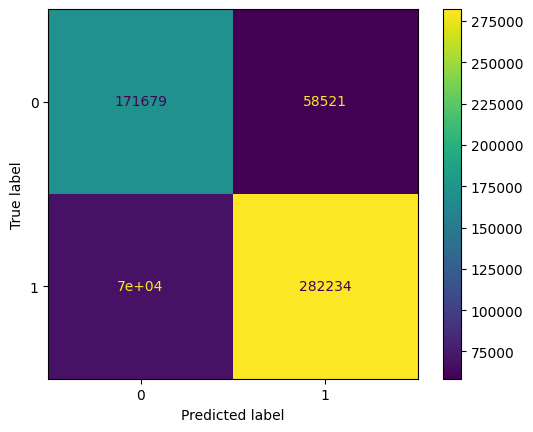

In [351]:
#lgbm classifier
scaler = MinMaxScaler(feature_range=(0, 1))
pipeline=Pipeline([('tr', scaler), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X_train,y_train)
TrainML(pipeline,X_train, y_train,5,SEED=42)

In [352]:
pipeline.fit(X_train, y_train)
y_preds=pipeline.predict(X_test)
y_prob=pipeline.predict_proba(X_test)[:,1]

[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.8s
[Pipeline] .............. (step 2 of 2) Processing lgbm, total=   4.7s


In [353]:
y_prob

array([0.52170512, 0.52170512, 0.52170512, ..., 0.39571433, 0.39571433,
       0.39571433])

In [354]:

reshaped_data = y_preds.reshape((int(len(y_preds)/200), 200, ))


In [355]:
predictions=[]
for i in reshaped_data:
    predictions.append(i.max())
predictions

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,


In [357]:
y_true=test_data['pass']

In [360]:
accuracy_score(y_true, predictions)

0.7588235294117647

In [361]:
df_test[df_test['xpass_situational']<.2]

,gameId,playId,frameId,week,WR_dir,WR_dis,WRx_standard,WRy_standard,T_dir,T_dis,...,neg_alignment,neg_Formations,off_xpass,QBdffy_RB,motion-momentum,receiverAlignment_3x2,QBdff_WR,pass,predicitons,predictions
21800,2022110300,3407,1,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0.536589,11.757573,-2.0,0,68.553812,0,0.005385,0.005385
21801,2022110300,3407,2,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0.536589,11.757573,-2.0,0,68.553812,0,0.005385,0.005385
21802,2022110300,3407,3,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0.536589,11.757573,-2.0,0,68.553812,0,0.005385,0.005385
21803,2022110300,3407,4,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0.536589,11.757573,-2.0,0,68.553812,0,0.005385,0.005385
21804,2022110300,3407,5,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0.536589,11.757573,-2.0,0,68.553812,0,0.005385,0.005385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305795,2022110700,3740,196,9,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0.536967,11.691006,-1.0,0,138.172050,0,0.034745,0.034745
305796,2022110700,3740,197,9,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0.536967,11.691006,-1.0,0,138.172050,0,0.034745,0.034745
305797,2022110700,3740,198,9,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0.536967,11.691006,-1.0,0,138.172050,0,0.034745,0.034745
305798,2022110700,3740,199,9,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0.536967,11.691006,-1.0,0,138.172050,0,0.034745,0.034745


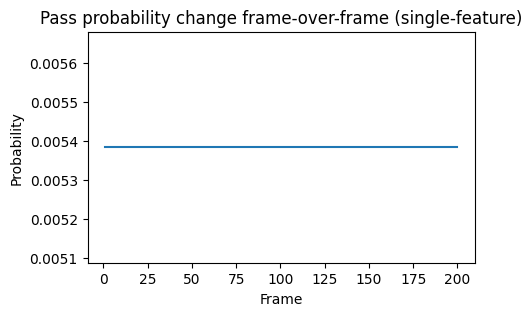

In [362]:
example=df_test[(df_test['gameId']==2022110300)& (df_test['playId']==3407)][['frameId', 'predictions']]
plt.figure(figsize=(5,3))
plt.title('Pass probability change frame-over-frame (single-feature)')
plt.xlabel('Frame')
plt.ylabel('Probability')
plt.plot(example['frameId'],example['predictions'])
plt.show()